In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


In [2]:
%%time
df=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df.head()

Wall time: 6.15 s


In [10]:
df.bin_1.value_counts(),df.nom_5.value_counts()

(0.0    474018
 1.0    107979
 Name: bin_1, dtype: int64, fc8fc7e56    977
 360a16627    972
 423976253    961
 7917d446c    961
 079b76328    960
 879c2ed83    960
 f4c4a7cc2    958
 e32171484    956
 251c8292d    954
 b2894f509    951
 b165c9589    951
 124963b67    950
 edd08fbe3    948
 bcdb1d6a1    947
 094b85efd    947
 691ebeae8    945
 3ad40eeef    945
 b33e135b5    944
 03ea75c83    942
 c8a903ab9    941
 4d701cd2a    941
 207bec5ff    941
 606509f50    940
 8e0f7217a    938
 b8f70e10b    936
 9e0154a54    934
 0d475c15f    933
 7d6c0cf07    931
 e32849ce1    929
 c9b03bd0c    928
             ... 
 8567e3930     22
 ee0884cf8     20
 471b15c2f     19
 4b93c32fd     18
 abd477977     18
 1b88f3b6a     17
 7d7c614e7     16
 ba3ec5b4e     16
 4a5e9c714     14
 d48b41023     14
 7b1a1b48c     14
 f4ace1f90     13
 8116aba72     13
 b578ca3d3     13
 15d09c0f3     13
 58aa1b824     12
 e8dca2f17     12
 44a2e6186     10
 89f532300     10
 7331b57f0      9
 f00b62582      9
 53554f

In [4]:
df.target.value_counts()

0    487677
1    112323
Name: target, dtype: int64

In [ ]:
df = df.apply(lambda group: group.interpolate(limit_direction='both'))
for col in df:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])
df.isna().sum()

In [11]:
df.fillna('-99999',inplace=True)

In [5]:
df.shape

(600000, 25)

In [6]:
df.isnull().any().sum()

23

In [8]:
%%time
import numpy as np
features_cyc = ['day', 'month']
for feature in features_cyc:
    df[feature+'_sin'] = np.sin((2*np.pi*df[feature])/max(df[feature]))
    df[feature+'_cos'] = np.cos((2*np.pi*df[feature])/max(df[feature]))
    df_test[feature+'_sin'] = np.sin((2*np.pi*df_test[feature])/max(df_test[feature]))
    df_test[feature+'_cos'] = np.cos((2*np.pi*df_test[feature])/max(df_test[feature]))
df = df.drop(features_cyc, axis=1)
df_test = df_test.drop(features_cyc, axis=1)


Wall time: 2.23 s


In [9]:
df.isnull().any().sum()

25

In [15]:
cols_missing_train = [col for col in df.columns if df[col].isnull().any()]
cols_missing_test = [col for col in df_test.columns if df_test[col].isnull().any()]

In [17]:
cols_missing_test

['bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_0',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos']

In [18]:
%%time
imp_cat = SimpleImputer(strategy='most_frequent')
df[cols_missing_train] = imp_cat.fit_transform(df[cols_missing_train])
df_test[cols_missing_test] = imp_cat.fit_transform(df_test[cols_missing_test])

KeyboardInterrupt: 

In [19]:
class categoricalfeature:
    def __init__(self,df,cat_feat,encoding_type,handle_NAN=False):
        #df pandas frames
        #cat_feature: list of categorical feature
        #encoding_type: lable,binary,one_hot
        self.df=df
        self.output_df=self.df.copy(deep=True)
        self.cat_feat=cat_feat
        self.encoding_type=encoding_type
        self.label_encoders=dict()
        
        if handle_NAN:
            for c in self.cat_feat:
                self.df.loc[:,c]= self.df.loc[:,c].astype(str).fillna('-99999')

    def _label_endcoding(self):
        for c in self.cat_feat:
            lbl=preprocessing.LabelEncoder()
            lbl.fit(self.df[c].values)
            self.output_df.loc[:,c]=lbl.transform(self.df[c].values)
            self.label_encoders[c]=lbl
        return self.output_df
            
    def transform(self):
        if self.encoding_type=='label':
            return self._label_endcoding()
        else:
            raise Exception("Encoding type not understand")

In [20]:
col=[c for c in df.columns if df[c].dtype=='object']
col

['bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5']

In [21]:
col=[c for c in df.columns if c not in ['id','target']]
#col=[c for c in df.columns if df[c].dtype=='object']
cat=categoricalfeature(df,cat_feat=col,encoding_type='label',handle_NAN=True)
catt=categoricalfeature(df_test,cat_feat=col,encoding_type='label',handle_NAN=True)
encoded_df=cat.transform()
encoded_df_test=catt.transform()

In [22]:
encoded_df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_1,ord_2,ord_3,ord_4,ord_5,target,day_sin,day_cos,month_sin,month_cos
0,0,0,0,0,0,0,2,4,3,5,...,0,3,2,20,56,0,1,4,9,10
1,1,1,1,0,0,1,2,3,0,6,...,2,5,4,23,151,0,3,6,0,3
2,2,0,1,0,0,0,2,6,3,0,...,5,2,13,15,105,0,2,1,4,5
3,3,2,0,0,0,0,2,0,3,3,...,4,4,0,2,140,0,4,2,9,10
4,4,0,2,0,1,0,2,5,3,2,...,2,1,7,2,50,0,2,1,5,9


In [23]:
encoded_df.bin_0.value_counts()

0    528377
1     53729
2     17894
Name: bin_0, dtype: int64

In [24]:
encoded_df_test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,600000,0,0,0,0,1,0,1,0,3,...,2,4,0,5,20,147,4,2,4,5
1,600001,0,0,0,0,1,2,0,4,5,...,0,4,1,13,13,140,6,0,2,1
2,600002,0,0,0,0,1,0,0,0,5,...,0,1,5,8,13,12,6,0,10,4
3,600003,1,0,0,0,0,2,1,0,2,...,0,1,3,12,1,0,5,5,10,4
4,600004,0,0,1,0,1,2,0,6,3,...,0,0,4,15,9,14,4,2,9,10


In [25]:
X=encoded_df.drop(["id","target"],axis=1)
Y=encoded_df["target"]

In [26]:
skf = StratifiedKFold(n_splits=15,shuffle=True)
skf.get_n_splits(X, Y)

for train_index, test_index in skf.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

TRAIN: [     0      1      3 ... 599997 599998 599999] TEST: [     2      7     14 ... 599931 599933 599988]
TRAIN: [     0      1      2 ... 599997 599998 599999] TEST: [     4     17     78 ... 599951 599959 599994]
TRAIN: [     0      1      2 ... 599996 599998 599999] TEST: [    27     49     84 ... 599970 599976 599997]
TRAIN: [     0      1      2 ... 599997 599998 599999] TEST: [    10     56     72 ... 599914 599949 599983]
TRAIN: [     0      1      2 ... 599997 599998 599999] TEST: [     9     20     25 ... 599971 599979 599981]
TRAIN: [     0      1      2 ... 599997 599998 599999] TEST: [     6     38     53 ... 599945 599980 599995]
TRAIN: [     0      1      2 ... 599997 599998 599999] TEST: [    26     62     80 ... 599990 599991 599992]
TRAIN: [     0      2      3 ... 599997 599998 599999] TEST: [     1     21     22 ... 599937 599964 599984]
TRAIN: [     1      2      3 ... 599996 599997 599999] TEST: [     0      8     19 ... 599961 599969 599998]
TRAIN: [     0     

In [14]:
months = [('month', i) for i in [2, 3, 4, 6, 12]]
days = [('day', i) for i in [2, 3, 4, 7]]

for f_p in days + months:
    for fun_suf in [(math.cos, '_cos'), (math.sin, '_sin')]:
        f, period = f_p
        func, suffix = fun_suf
        df[f + suffix + str(period)] = train[f].apply(lambda i: func(math.pi * i / period) if i == i else 0.0)

In [ ]:
'''from sklearn.metrics import confusion_matrix,accuracy_score
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(objective='binary', random_state=5)

skf = StratifiedKFold(n_splits=10,shuffle=True)
skf.get_n_splits(X, Y)
accuracy=[]

for train_index, test_index in skf.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    #lgbm.fit(x_train,y_train)
    #pred=lgbm.predict(x_test)
    #zscore=accuracy_score(pred,y_test)
    #accuracy.append(score)
#print(accuracy)'''

[1]	training's binary_logloss: 0.474489	valid_0's binary_logloss: 0.474599
Training until validation scores don't improve for 50 rounds
[2]	training's binary_logloss: 0.469319	valid_0's binary_logloss: 0.469271
[3]	training's binary_logloss: 0.465137	valid_0's binary_logloss: 0.465112
[4]	training's binary_logloss: 0.461335	valid_0's binary_logloss: 0.461382
[5]	training's binary_logloss: 0.458348	valid_0's binary_logloss: 0.458321
[6]	training's binary_logloss: 0.456185	valid_0's binary_logloss: 0.456164
[7]	training's binary_logloss: 0.453905	valid_0's binary_logloss: 0.453752
[8]	training's binary_logloss: 0.451533	valid_0's binary_logloss: 0.451423
[9]	training's binary_logloss: 0.449735	valid_0's binary_logloss: 0.449541
[10]	training's binary_logloss: 0.448267	valid_0's binary_logloss: 0.448137
[11]	training's binary_logloss: 0.446532	valid_0's binary_logloss: 0.446341
[12]	training's binary_logloss: 0.444658	valid_0's binary_logloss: 0.444327
[13]	training's binary_logloss: 0.44

[111]	training's binary_logloss: 0.412332	valid_0's binary_logloss: 0.412702
[112]	training's binary_logloss: 0.412271	valid_0's binary_logloss: 0.412656
[113]	training's binary_logloss: 0.4122	valid_0's binary_logloss: 0.41262
[114]	training's binary_logloss: 0.412129	valid_0's binary_logloss: 0.412545
[115]	training's binary_logloss: 0.41205	valid_0's binary_logloss: 0.412483
[116]	training's binary_logloss: 0.412	valid_0's binary_logloss: 0.412458
[117]	training's binary_logloss: 0.41196	valid_0's binary_logloss: 0.412421
[118]	training's binary_logloss: 0.411888	valid_0's binary_logloss: 0.412372
[119]	training's binary_logloss: 0.411836	valid_0's binary_logloss: 0.412316
[120]	training's binary_logloss: 0.411782	valid_0's binary_logloss: 0.412257
[121]	training's binary_logloss: 0.411658	valid_0's binary_logloss: 0.412138
[122]	training's binary_logloss: 0.411501	valid_0's binary_logloss: 0.412004
[123]	training's binary_logloss: 0.411459	valid_0's binary_logloss: 0.411981
[124]	t

[220]	training's binary_logloss: 0.405974	valid_0's binary_logloss: 0.407616
[221]	training's binary_logloss: 0.405936	valid_0's binary_logloss: 0.407598
[222]	training's binary_logloss: 0.4059	valid_0's binary_logloss: 0.407584
[223]	training's binary_logloss: 0.405871	valid_0's binary_logloss: 0.407567
[224]	training's binary_logloss: 0.405851	valid_0's binary_logloss: 0.407562
[225]	training's binary_logloss: 0.405835	valid_0's binary_logloss: 0.407559
[226]	training's binary_logloss: 0.405807	valid_0's binary_logloss: 0.407554
[227]	training's binary_logloss: 0.405789	valid_0's binary_logloss: 0.407557
[228]	training's binary_logloss: 0.405773	valid_0's binary_logloss: 0.407562
[229]	training's binary_logloss: 0.405704	valid_0's binary_logloss: 0.407536
[230]	training's binary_logloss: 0.40568	valid_0's binary_logloss: 0.407522
[231]	training's binary_logloss: 0.405659	valid_0's binary_logloss: 0.407513
[232]	training's binary_logloss: 0.405582	valid_0's binary_logloss: 0.407436
[2

[329]	training's binary_logloss: 0.402496	valid_0's binary_logloss: 0.405734
[330]	training's binary_logloss: 0.402427	valid_0's binary_logloss: 0.405674
[331]	training's binary_logloss: 0.402407	valid_0's binary_logloss: 0.405691
[332]	training's binary_logloss: 0.402386	valid_0's binary_logloss: 0.405686
[333]	training's binary_logloss: 0.402372	valid_0's binary_logloss: 0.405698
[334]	training's binary_logloss: 0.402345	valid_0's binary_logloss: 0.405693
[335]	training's binary_logloss: 0.402332	valid_0's binary_logloss: 0.405693
[336]	training's binary_logloss: 0.402308	valid_0's binary_logloss: 0.405699
[337]	training's binary_logloss: 0.402278	valid_0's binary_logloss: 0.405684
[338]	training's binary_logloss: 0.402264	valid_0's binary_logloss: 0.405687
[339]	training's binary_logloss: 0.402244	valid_0's binary_logloss: 0.405695
[340]	training's binary_logloss: 0.402204	valid_0's binary_logloss: 0.405668
[341]	training's binary_logloss: 0.402191	valid_0's binary_logloss: 0.405663

[436]	training's binary_logloss: 0.399994	valid_0's binary_logloss: 0.404847
[437]	training's binary_logloss: 0.399969	valid_0's binary_logloss: 0.404845
[438]	training's binary_logloss: 0.399951	valid_0's binary_logloss: 0.404842
[439]	training's binary_logloss: 0.399938	valid_0's binary_logloss: 0.40485
[440]	training's binary_logloss: 0.399921	valid_0's binary_logloss: 0.404852
[441]	training's binary_logloss: 0.399883	valid_0's binary_logloss: 0.404808
[442]	training's binary_logloss: 0.399864	valid_0's binary_logloss: 0.404793
[443]	training's binary_logloss: 0.399841	valid_0's binary_logloss: 0.404789
[444]	training's binary_logloss: 0.399818	valid_0's binary_logloss: 0.40478
[445]	training's binary_logloss: 0.399787	valid_0's binary_logloss: 0.40475
[446]	training's binary_logloss: 0.399771	valid_0's binary_logloss: 0.404745
[447]	training's binary_logloss: 0.399756	valid_0's binary_logloss: 0.404727
[448]	training's binary_logloss: 0.399725	valid_0's binary_logloss: 0.404715
[4

[545]	training's binary_logloss: 0.397887	valid_0's binary_logloss: 0.404306
[546]	training's binary_logloss: 0.397871	valid_0's binary_logloss: 0.404311
[547]	training's binary_logloss: 0.397859	valid_0's binary_logloss: 0.404311
[548]	training's binary_logloss: 0.397835	valid_0's binary_logloss: 0.40429
[549]	training's binary_logloss: 0.397798	valid_0's binary_logloss: 0.40427
[550]	training's binary_logloss: 0.39778	valid_0's binary_logloss: 0.404272
[551]	training's binary_logloss: 0.397767	valid_0's binary_logloss: 0.404276
[552]	training's binary_logloss: 0.39775	valid_0's binary_logloss: 0.404275
[553]	training's binary_logloss: 0.397737	valid_0's binary_logloss: 0.404276
[554]	training's binary_logloss: 0.397725	valid_0's binary_logloss: 0.404282
[555]	training's binary_logloss: 0.39771	valid_0's binary_logloss: 0.404281
[556]	training's binary_logloss: 0.397691	valid_0's binary_logloss: 0.404275
[557]	training's binary_logloss: 0.39767	valid_0's binary_logloss: 0.40426
[558]	

[653]	training's binary_logloss: 0.395973	valid_0's binary_logloss: 0.40395
[654]	training's binary_logloss: 0.395962	valid_0's binary_logloss: 0.403949
[655]	training's binary_logloss: 0.395945	valid_0's binary_logloss: 0.403939
[656]	training's binary_logloss: 0.395932	valid_0's binary_logloss: 0.403946
[657]	training's binary_logloss: 0.395919	valid_0's binary_logloss: 0.403946
[658]	training's binary_logloss: 0.395905	valid_0's binary_logloss: 0.403942
[659]	training's binary_logloss: 0.395893	valid_0's binary_logloss: 0.403945
[660]	training's binary_logloss: 0.39587	valid_0's binary_logloss: 0.403934
[661]	training's binary_logloss: 0.395855	valid_0's binary_logloss: 0.403946
[662]	training's binary_logloss: 0.395837	valid_0's binary_logloss: 0.403943
[663]	training's binary_logloss: 0.395815	valid_0's binary_logloss: 0.40395
[664]	training's binary_logloss: 0.395799	valid_0's binary_logloss: 0.403957
[665]	training's binary_logloss: 0.395783	valid_0's binary_logloss: 0.403949
[6

[761]	training's binary_logloss: 0.394272	valid_0's binary_logloss: 0.403949
[762]	training's binary_logloss: 0.394257	valid_0's binary_logloss: 0.403944
[763]	training's binary_logloss: 0.394246	valid_0's binary_logloss: 0.403939
[764]	training's binary_logloss: 0.394229	valid_0's binary_logloss: 0.403929
[765]	training's binary_logloss: 0.394215	valid_0's binary_logloss: 0.403921
[766]	training's binary_logloss: 0.3942	valid_0's binary_logloss: 0.403917
[767]	training's binary_logloss: 0.394188	valid_0's binary_logloss: 0.403917
[768]	training's binary_logloss: 0.394177	valid_0's binary_logloss: 0.403922
[769]	training's binary_logloss: 0.394157	valid_0's binary_logloss: 0.403939
[770]	training's binary_logloss: 0.39414	valid_0's binary_logloss: 0.403945
[771]	training's binary_logloss: 0.394126	valid_0's binary_logloss: 0.403947
[772]	training's binary_logloss: 0.394094	valid_0's binary_logloss: 0.403938
[773]	training's binary_logloss: 0.394076	valid_0's binary_logloss: 0.403939
[7

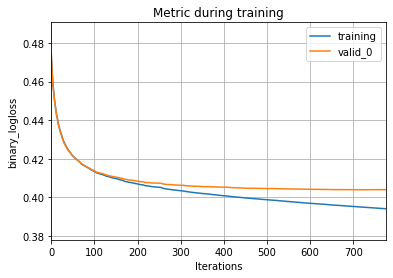

In [37]:
import lightgbm as lgb
import matplotlib.pyplot as plt
params={}
params['learning_rate']= 0.1700
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['sub_feature']=0.5
params['num_leaves']= 10
params['min_data']=30
params['max_depth']=10
d_train = lgb.Dataset(x_train, label=y_train )
d_test =  lgb.Dataset( x_test, label= y_test)
evals_result={}
lgb.train()
model=lgb.train(params,d_train,1000,
                valid_sets=[d_test,d_train],verbose_eval=True,
                early_stopping_rounds=50,evals_result=evals_result)
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()

[1]	valid_0's binary_logloss: 0.474271
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.468593
[3]	valid_0's binary_logloss: 0.464431
[4]	valid_0's binary_logloss: 0.46017
[5]	valid_0's binary_logloss: 0.457219
[6]	valid_0's binary_logloss: 0.454532
[7]	valid_0's binary_logloss: 0.451648
[8]	valid_0's binary_logloss: 0.449658
[9]	valid_0's binary_logloss: 0.448201
[10]	valid_0's binary_logloss: 0.446828
[11]	valid_0's binary_logloss: 0.4454
[12]	valid_0's binary_logloss: 0.44369
[13]	valid_0's binary_logloss: 0.441681
[14]	valid_0's binary_logloss: 0.44078
[15]	valid_0's binary_logloss: 0.439526
[16]	valid_0's binary_logloss: 0.438649
[17]	valid_0's binary_logloss: 0.437241
[18]	valid_0's binary_logloss: 0.436377
[19]	valid_0's binary_logloss: 0.43521
[20]	valid_0's binary_logloss: 0.43448
[21]	valid_0's binary_logloss: 0.433578
[22]	valid_0's binary_logloss: 0.432621
[23]	valid_0's binary_logloss: 0.431834
[24]	valid_0's binary_logloss: 0.43

[204]	valid_0's binary_logloss: 0.407598
[205]	valid_0's binary_logloss: 0.407494
[206]	valid_0's binary_logloss: 0.407422
[207]	valid_0's binary_logloss: 0.407422
[208]	valid_0's binary_logloss: 0.407429
[209]	valid_0's binary_logloss: 0.407427
[210]	valid_0's binary_logloss: 0.407383
[211]	valid_0's binary_logloss: 0.407387
[212]	valid_0's binary_logloss: 0.407358
[213]	valid_0's binary_logloss: 0.407349
[214]	valid_0's binary_logloss: 0.407303
[215]	valid_0's binary_logloss: 0.407299
[216]	valid_0's binary_logloss: 0.407305
[217]	valid_0's binary_logloss: 0.40725
[218]	valid_0's binary_logloss: 0.407103
[219]	valid_0's binary_logloss: 0.407017
[220]	valid_0's binary_logloss: 0.407002
[221]	valid_0's binary_logloss: 0.406986
[222]	valid_0's binary_logloss: 0.406967
[223]	valid_0's binary_logloss: 0.406927
[224]	valid_0's binary_logloss: 0.406802
[225]	valid_0's binary_logloss: 0.406784
[226]	valid_0's binary_logloss: 0.406766
[227]	valid_0's binary_logloss: 0.406703
[228]	valid_0's b

[409]	valid_0's binary_logloss: 0.404446
[410]	valid_0's binary_logloss: 0.404444
[411]	valid_0's binary_logloss: 0.40444
[412]	valid_0's binary_logloss: 0.404452
[413]	valid_0's binary_logloss: 0.40445
[414]	valid_0's binary_logloss: 0.404454
[415]	valid_0's binary_logloss: 0.404451
[416]	valid_0's binary_logloss: 0.404458
[417]	valid_0's binary_logloss: 0.404477
[418]	valid_0's binary_logloss: 0.404481
[419]	valid_0's binary_logloss: 0.404475
[420]	valid_0's binary_logloss: 0.404475
[421]	valid_0's binary_logloss: 0.404472
[422]	valid_0's binary_logloss: 0.404473
[423]	valid_0's binary_logloss: 0.404445
[424]	valid_0's binary_logloss: 0.40439
[425]	valid_0's binary_logloss: 0.404391
[426]	valid_0's binary_logloss: 0.404378
[427]	valid_0's binary_logloss: 0.404374
[428]	valid_0's binary_logloss: 0.404372
[429]	valid_0's binary_logloss: 0.404378
[430]	valid_0's binary_logloss: 0.40438
[431]	valid_0's binary_logloss: 0.404392
[432]	valid_0's binary_logloss: 0.404366
[433]	valid_0's bina

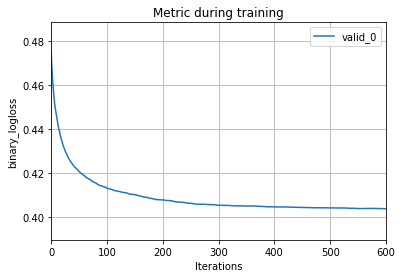

In [35]:
import lightgbm as lgb
import matplotlib.pyplot as plt

params={}
params['learning_rate']= 0.175
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['sub_feature']=0.5
params['num_leaves']= 10
params['min_data']=30
params['max_depth']=10
d_train = lgb.Dataset(x_train, label=y_train )
d_test =  lgb.Dataset( x_test, label= y_test)
#d_train=lgb.Dataset(X,label=Y)

evals_result = {}

model2=lgb.train(params,d_train,800,
                valid_sets=d_test,verbose_eval=True,
                early_stopping_rounds=50,evals_result=evals_result)

ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()

In [30]:
encoded_df_test.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day_sin',
       'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [31]:
encoded_df_test=encoded_df_test.drop(['id'],axis=1)
y_pred=model.predict(encoded_df_test)

In [32]:
y_pred

array([0.29284535, 0.2407599 , 0.14351193, ..., 0.34842298, 0.1881282 ,
       0.21137527])

In [33]:
for i in range(0,100):
    if (y_pred[i] >= 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] =0
len(y_pred) 

400000

In [34]:
%%time
sample = pd.read_csv("sample_submission.csv")
sample.loc[:, "target"] = y_pred
sample.to_csv("submission_using_lgbm.csv", index=False)

Wall time: 3.28 s


In [16]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(allTrainData, allTrainLabels)

In [ ]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values
feature_importance_df = pd.DataFrame()
predictions = df_test[['ID_code']]

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    print("FOLD: ", fold, "TRAIN:", train_index, "TEST:", test_index)
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    N = 5
    p_valid = 0
    yp = 0
    
    for i in range(N):
        
        trn_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_valid, label = y_valid)
        
        
        
        lgb_clf = lgb.train(lgb_params,
                   trn_data,
                   100000,
                   valid_sets = [trn_data, val_data],
                    verbose_eval = 5000,
                    early_stopping_rounds = 3000)
        
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    
    #Get importance of the fold when predicting test set
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions['fold{}'.format(fold+1)] = yp/N